<a href="https://colab.research.google.com/github/joyalkenus/Project_imageSearch/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is the major run file of this project
- Aims to give a user friendly interface to interact with the system
- aims to integrate the BERT LLM to the RAM model to achieve proper image search for the user description.

In [37]:
#@title Import  Libraries and dependencies
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Widget for user interaction
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os


In [38]:
!pip install salesforce-lavis

In [54]:
#@title Asking for permissions for G-drive and Repo cloning
from google.colab import drive
drive.mount('/content/drive')
#Cloning the repository
!git clone https://github.com/joyalkenus/Project_imageSearch.git
%cd Project_imageSearch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'Project_imageSearch'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (792/792), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 792 (delta 418), reused 683 (delta 359), pack-reused 0
Receiving objects: 100% (792/792), 32.45 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (418/418), done.
/content/Project_imageSearch/Project_imageSearch/Project_imageSearch


In [40]:
#@title Install Transformers and its dependencies
!pip install transformers
!pip install timm transformers fairscale pycocoevalcap

clear_output()

In [41]:
#@title Model Selection
model_widget = widgets.Dropdown(
    options=["RAM", "Tag2Text"],
    value="RAM",
    description="Select mdoel:"
)
display(model_widget)
model = model_widget.value

Dropdown(description='Select mdoel:', options=('RAM', 'Tag2Text'), value='RAM')

In [42]:
#@title Downloading checkpoint function
def download_checkpoints(model):
    print('You selected', model)
    if not os.path.exists('pretrained'):
        os.makedirs('pretrained')

    if model == "RAM":
        ram_weights_path = 'pretrained/ram_swin_large_14m.pth'
        if not os.path.exists(ram_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth -O pretrained/ram_swin_large_14m.pth
        else:
            print("RAM weights already downloaded!")
    else:
        tag2text_weights_path = 'pretrained/tag2text_swin_14m.pth'
        if not os.path.exists(tag2text_weights_path):
            !wget https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/tag2text_swin_14m.pth -O pretrained/tag2text_swin_14m.pth
        else:
            print("Tag2Text weights already downloaded!")

download_checkpoints(model)
print(model, 'weights are downloaded!')

You selected RAM
--2024-02-22 15:30:48--  https://huggingface.co/spaces/xinyu1205/Recognize_Anything-Tag2Text/resolve/main/ram_swin_large_14m.pth
Resolving huggingface.co (huggingface.co)... 65.8.178.12, 65.8.178.118, 65.8.178.27, ...
Connecting to huggingface.co (huggingface.co)|65.8.178.12|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth [following]
--2024-02-22 15:30:49--  https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/e6/78/e678f8565485a3f321b1180e4c7e1e18a89a9295028358eedffb98981b37e11a/15c729c793af28b9d107c69f85836a1356d76ea830d4714699fb62e55fcc08ed?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ram_swin_large_14m.pth%3B+filename%3D%22ram_swin_large_14m.p

In [43]:
#@title Importing necesssary Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model1 = BertModel.from_pretrained('bert-base-uncased')


Use the Bert model to the capion data set



In [44]:
#@title Extracting the image data and reading it
!python extract.py
df = pd.read_csv('image_tags.csv')

2024-02-22 15:32:21.339967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 15:32:21.340050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 15:32:21.349538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 15:32:24.883367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/outpu

In [45]:
df['Captions']

0    ['three plates of food on a table with utensils']
1            ['a boy and a girl posing for a picture']
2    ['a young boy sitting in a chair with flowers ...
3    ['a group of people standing around a decorate...
4    ['a man sitting on a chair holding a cell phone']
5      ['a group of young men sitting around a table']
6    ['a girl in a school uniform smiling for the c...
7    ['a man sitting on top of a motorcycle next to...
8             ['two men sitting on a bench in a park']
Name: Captions, dtype: object

In [59]:
import ast
if isinstance(df['Captions'].iloc[0], str):
    df['Captions_split'] = df['Captions'].apply(lambda x: ast.literal_eval(x)[0])
else:
    # Directly extract the sentence if already a list
    df['Captions_split'] = df['Captions'].apply(lambda x: x[0])

df['Captions_split']

0        three plates of food on a table with utensils
1                a boy and a girl posing for a picture
2    a young boy sitting in a chair with flowers in...
3    a group of people standing around a decorated ...
4        a man sitting on a chair holding a cell phone
5          a group of young men sitting around a table
6    a girl in a school uniform smiling for the camera
7    a man sitting on top of a motorcycle next to a...
8                 two men sitting on a bench in a park
Name: Captions_split, dtype: object

In [60]:
df['concatenated'] = df['Captions_split']+','+ df['Tags']
df['concatenated']
df['Concat_split'] = df['concatenated'].str.replace('|', ',', regex=False)
df['Concat_split'][0]

'three plates of food on a table with utensils,condiment , counter top , table , dinning table , plate , fill , food , fork , meal , noodle , peak , platter , salad , silverware , utensil , yellow'

In [61]:
#@title Function to encode text into numerical format and perform necessary tokenization
def encode_text(text):
    # Your encoding logic here
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        output = model1(**encoded_input)
    text= output.last_hidden_state.mean(dim=1).numpy()
    return text

# Apply split on each element of the Series
df['Tags_split'] = df['Tags'].apply(lambda x: x.split(' | '))
averaged_embeddings = []
# Processing each row in the DataFrame
for index, row in df.iterrows():
    tags_list = row['Concat_split']  # Now this is already a list of tags
    encoded_tags = encode_text(tags_list)
    avg_embedding = np.mean(encoded_tags, axis=0)
    averaged_embeddings.append(avg_embedding)
    print(tags_list)
embeddings = np.vstack(averaged_embeddings) # Encode the list of tags

    #print(encoded_tags)  # Or use the encoded_tags as needed
print(embeddings)

three plates of food on a table with utensils,condiment , counter top , table , dinning table , plate , fill , food , fork , meal , noodle , peak , platter , salad , silverware , utensil , yellow
a boy and a girl posing for a picture,baseball hat , boy , child , floor , girl , man , pose , selfie , shirt , sit , smile , stool
a young boy sitting in a chair with flowers in the background,baby , boy , chair , child , green , photo , shirt , sit , stool
a group of people standing around a decorated float,cart , crowded , decorate , deity , festival , hindu temple , person , place , shrine , stand , temple , walk , worship
a man sitting on a chair holding a cell phone,catch , ceiling fan , smartphone , chair , table , person , man , phone , room , sit
a group of young men sitting around a table,boy , chair , table , man , round table , school uniform , sit , tie
a girl in a school uniform smiling for the camera,blue , girl , lanyard , medal , neck , pose , selfie , smile , stand , tie , we

0        three plates of food on a table with utensils
1                a boy and a girl posing for a picture
2    a young boy sitting in a chair with flowers in...
3    a group of people standing around a decorated ...
4        a man sitting on a chair holding a cell phone
5          a group of young men sitting around a table
6    a girl in a school uniform smiling for the camera
7    a man sitting on top of a motorcycle next to a...
8                 two men sitting on a bench in a park
Name: Captions_split, dtype: object

'three plates of food on a table with utensils,condiment , counter top , table , dinning table , plate , fill , food , fork , meal , noodle , peak , platter , salad , silverware , utensil , yellow'

In [62]:
#@title Image Search
text_input = widgets.Text(
    description='Enter Text:',
    placeholder='Type something'
)
# Create a button widget
button = widgets.Button(description="Submit")
# Output widget to display results
output = widgets.Output()
#------------------------------
#Function to confirm what is being searched
def on_button_clicked(b):
    global user_input
    user_input = text_input.value # Assign the input text to user_input variable
    #Encode user embedding


    with output:
        print(f"You entered: {user_input}")

# Bind the button click event to the function
button.on_click(on_button_clicked)

# Display the widgets
display(text_input, button, output)

Text(value='', description='Enter Text:', placeholder='Type something')

Button(description='Submit', style=ButtonStyle())

Output()

In [79]:
#@title Stacking all the image data into a numpy array to perform search
# Assuming df['Tags'] contains the embeddings
print(user_input)
user_embedding= encode_text(user_input)

two boys sitting on a bench


In [80]:
#@title Checking the dimensions of both arrays
print("user_embedding shape:", np.array([user_embedding]).shape)
print("embeddings shape:", embeddings.shape)
#rint(user_embedding)


user_embedding shape: (1, 1, 768)
embeddings shape: (9, 768)


In [81]:
#@title Major hurdle faced with dimensions being wrong. corrected by reshaping the
# Reshape user_embedding to be two-dimensional
user_embedding = user_embedding.reshape(1, -1)

# Now user_embedding should have the shape (1, 768)
print("Reshaped user_embedding shape:", user_embedding.shape)


Reshaped user_embedding shape: (1, 768)


5
The most similar image is this: /content/drive/My Drive/ImageSample/YAL.jpg


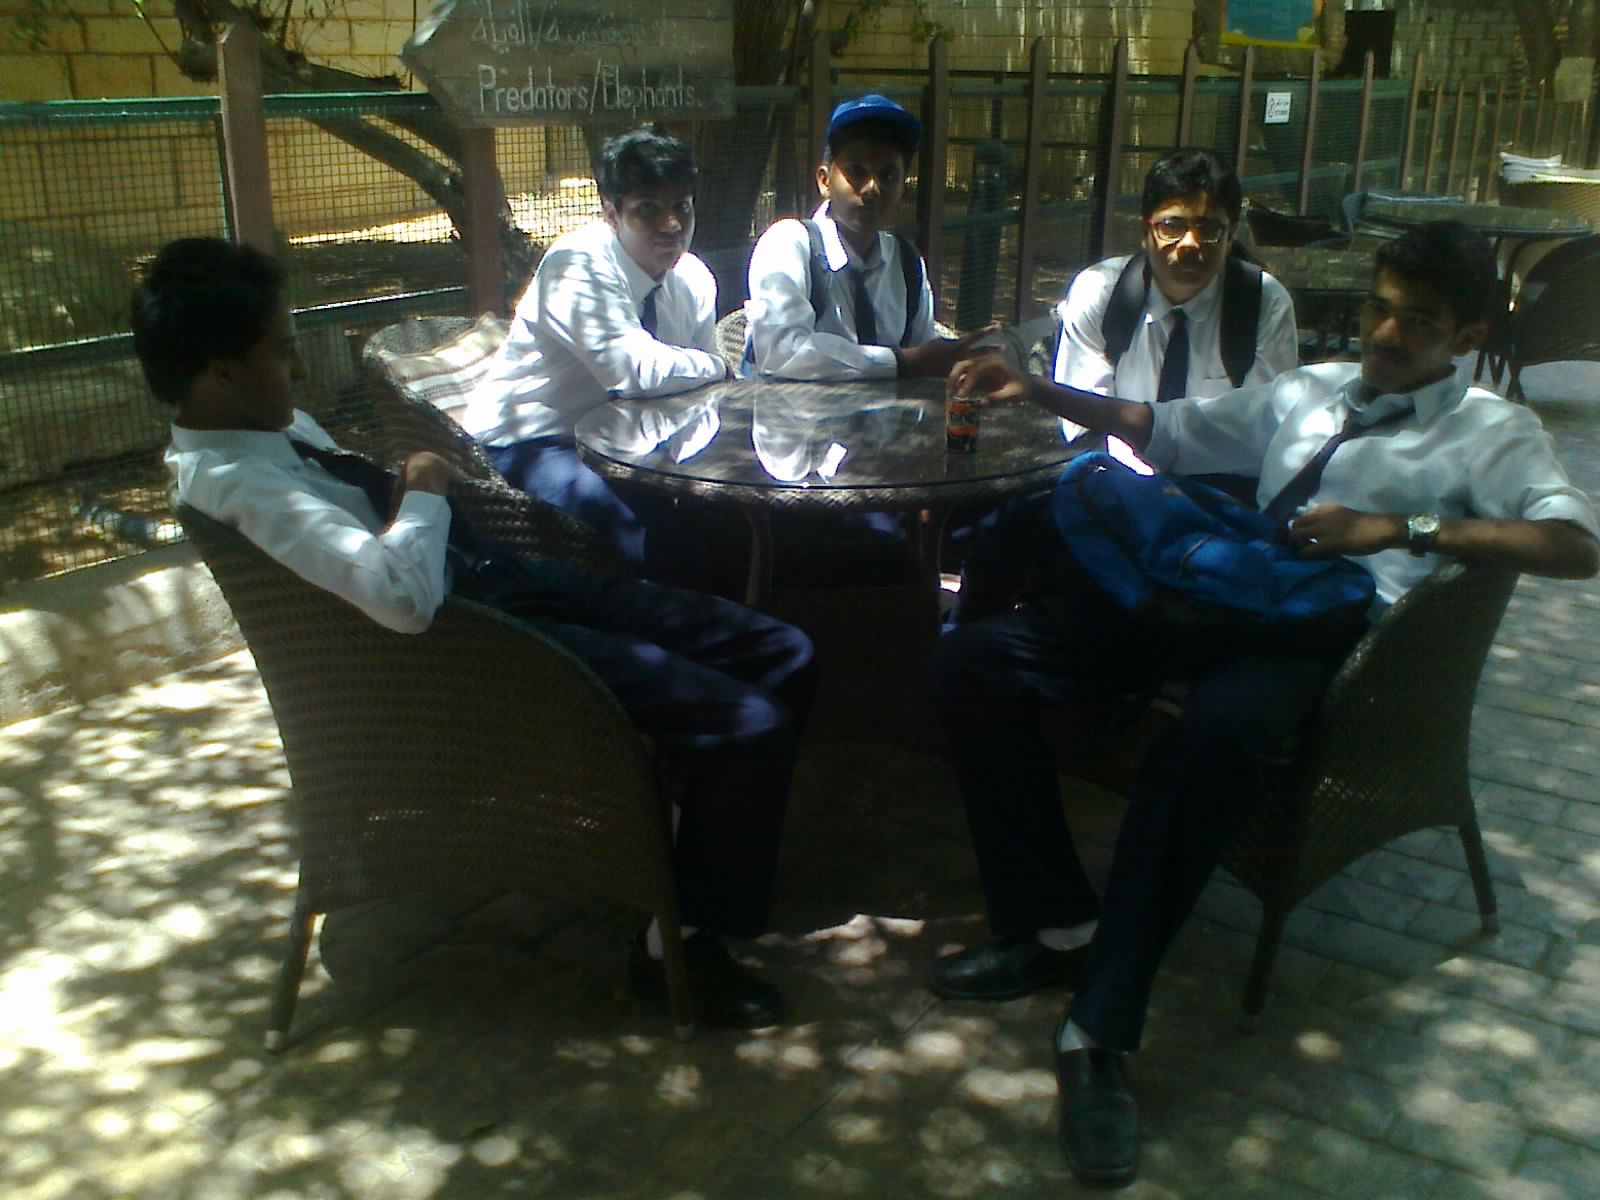

Output()

In [82]:
#@title Calculate Similarity Function and Display the most similar image

# Calculate cosine similarities
similarities = cosine_similarity(user_embedding, embeddings)

# Find the best match
best_match_index = similarities.argmax()
print(best_match_index)
best_match_image_path = df.iloc[best_match_index]['image_path']

print(f"The most similar image is this: {best_match_image_path}")
image_dropdown = widgets.Dropdown(
    options=best_match_image_path,
    description='Select Image:',
)
image_preview = widgets.Output()
# Set the initial image preview

display(Image(filename= best_match_image_path, width=400))
image_preview